In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [2]:
#Upload Data From CSV to dataframe
data = pd.read_csv("data2.csv")

In [3]:
#Remove columns with missing values more than threshold
threshold = 0.2
missing_percentage = data.isnull().sum() / len(data)
filtered_data = data.loc[:, missing_percentage <= threshold]

In [4]:
#Seperate categorical and numerical columns
categorical_cols = filtered_data.select_dtypes(include=['object']).columns
numerical_cols = filtered_data.select_dtypes(exclude=['object']).columns

In [5]:
#Label Encoding for categorical columns and impute missing values for numerical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
    label_encoders[col] = le

imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data_numerical = pd.DataFrame(imputer.fit_transform(filtered_data[numerical_cols]), columns=numerical_cols)
imputed_data = pd.concat([imputed_data_numerical, filtered_data[categorical_cols]], axis=1)


C:\Users\eric9\AppData\Local\Temp\ipykernel_40860\374195165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
C:\Users\eric9\AppData\Local\Temp\ipykernel_40860\374195165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))


In [6]:
X = imputed_data.drop('AKI', axis=1)
y = imputed_data['AKI']

In [7]:
# Lasso Feature Selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Assuming `X` is your feature matrix and `y` is your target variable
lasso = Lasso(alpha=0.01, random_state=42)  # Adjust alpha as needed
lasso.fit(X, y)

# Use SelectFromModel to select important features
model = SelectFromModel(lasso, prefit=True)
X_selected = model.transform(X)

# Get the selected feature names
selected_features = X.columns[(model.get_support())]
print("Selected Features:", selected_features)

Selected Features: Index(['los_hospital', 'anchor_age', 'glucose_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'hematocrit_max', 'wbc_max', 'bicarbonate_max', 'bun_max',
       'calcium_max', 'chloride_max', 'creatinine_max', 'glucose_max',
       'sodium_max', 'pt_max', 'ptt_max', 'alt_max', 'bilirubin_total_max',
       'admission_type', 'insurance'],
      dtype='object')


C:\Users\eric9\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [8]:
# Identify the target variable and scale the values
X = X[selected_features]  
y = imputed_data['AKI']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [10]:
# Train the model
knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
# Making Predictions
y_pred = knn_model.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]

In [12]:
#   Plot the ROC curve
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy}")

auc = roc_auc_score(y_test, y_pred_prob)
print(f"KNN AUC Score: {auc}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

KNN Accuracy: 0.7876923076923077
KNN AUC Score: 0.803825391882072
Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55        78
         1.0       0.86      0.86      0.86       247

    accuracy                           0.79       325
   macro avg       0.71      0.71      0.71       325
weighted avg       0.79      0.79      0.79       325

Confusion Matrix:
[[ 43  35]
 [ 34 213]]


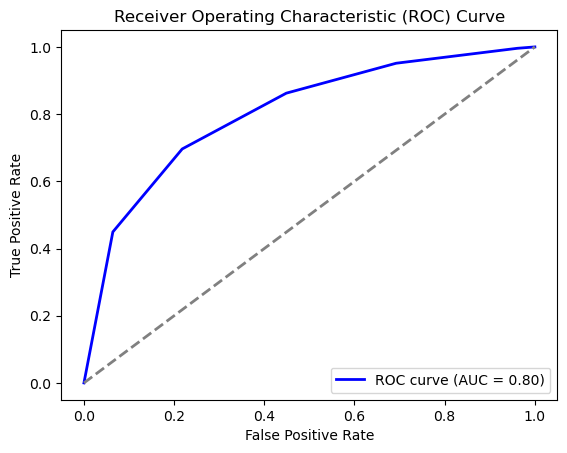

In [13]:
# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()